In [2]:
from numpy import *
import matplotlib.pylab as plt

In [4]:
def loadDataSet(fileName):
    """ 加载数据
        解析以tab键分隔的文件中的浮点数
    Returns：
        dataMat ：  feature 对应的数据集
        labelMat ： feature 对应的分类标签，即类别标签
    """
    # 获取样本特征的总数，不算最后的目标变量 
    numFeat = len(open(fileName).readline().split('\t')) - 1
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        # 读取每一行
        lineArr = []
        # 删除一行中以tab分隔的数据前后的空白符号
        curLine = line.strip().split('\t')
        # i 从0到2，不包括2 
        for i in range(numFeat):
            # 将数据添加到lineArr List中，每一行数据测试数据组成一个行向量           
            lineArr.append(float(curLine[i]))
            # 将测试数据的输入数据部分存储到dataMat 的List中
        dataMat.append(lineArr)
        # 将每一行的最后一个数据，即类别，或者叫目标变量存储到labelMat List中
        labelMat.append(float(curLine[-1]))
    return dataMat, labelMat

接下来是几种线性回归方程

In [6]:
#最一般的线性回归
def standRegres(xArr, yArr):
    '''
    Description：
        线性回归
    Args:
        xArr ：输入的样本数据，包含每个样本数据的 feature
        yArr ：对应于输入数据的类别标签，也就是每个样本对应的目标变量
    Returns:
        ws：回归系数
    '''

    # mat()函数将xArr，yArr转换为矩阵 mat().T 代表的是对矩阵进行转置操作
    xMat = mat(xArr)
    yMat = mat(yArr).T
    # 矩阵乘法的条件是左矩阵的列数等于右矩阵的行数
    xTx = xMat.T * xMat
    # 因为要用到xTx的逆矩阵，所以事先需要确定计算得到的xTx是否可逆，条件是矩阵的行列式不为0
    # linalg.det() 函数是用来求得矩阵的行列式的，如果矩阵的行列式为0，则这个矩阵是不可逆的，就无法进行接下来的运算                   
    if linalg.det(xTx) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    # 最小二乘法
    # http://www.apache.wiki/pages/viewpage.action?pageId=5505133
    # 书中的公式，求得w的最优解
    ws = xTx.I * (xMat.T * yMat)
    return ws

In [7]:
def lwlr(testPoint, xArr, yArr, k=1.0):
    '''
        Description：
            局部加权线性回归，在待预测点附近的每个点赋予一定的权重，在子集上基于最小均方差来进行普通的回归。
        Args：
            testPoint：样本点
            xArr：样本的特征数据，即 feature
            yArr：每个样本对应的类别标签，即目标变量
            k:关于赋予权重矩阵的核的一个参数，与权重的衰减速率有关
        Returns:
            testPoint * ws：数据点与具有权重的系数相乘得到的预测点
        Notes:
            这其中会用到计算权重的公式，w = e^((x^((i))-x) / -2k^2)
            理解：x为某个预测点，x^((i))为样本点，样本点距离预测点越近，贡献的误差越大（权值越大），越远则贡献的误差越小（权值越小）。
            关于预测点的选取，在我的代码中取的是样本点。其中k是带宽参数，控制w（钟形函数）的宽窄程度，类似于高斯函数的标准差。
            算法思路：假设预测点取样本点中的第i个样本点（共m个样本点），遍历1到m个样本点（含第i个），算出每一个样本点与预测点的距离，
            也就可以计算出每个样本贡献误差的权值，可以看出w是一个有m个元素的向量（写成对角阵形式）。
    '''
    # mat() 函数是将array转换为矩阵的函数， mat().T 是转换为矩阵之后，再进行转置操作
    xMat = mat(xArr)
    yMat = mat(yArr).T
    # 获得xMat矩阵的行数
    m = shape(xMat)[0]
    # eye()返回一个对角线元素为1，其他元素为0的二维数组，创建权重矩阵weights，该矩阵为每个样本点初始化了一个权重                   
    weights = mat(eye((m)))
    for j in range(m):
        # testPoint 的形式是 一个行向量的形式
        # 计算 testPoint 与输入样本点之间的距离，然后下面计算出每个样本贡献误差的权值
        diffMat = testPoint - xMat[j, :]
        # k控制衰减的速度
        weights[j, j] = exp(diffMat * diffMat.T / (-2.0 * k**2))
    # 根据矩阵乘法计算 xTx ，其中的 weights 矩阵是样本点对应的权重矩阵
    xTx = xMat.T * (weights * xMat)
    if linalg.det(xTx) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    # 计算出回归系数的一个估计
    ws = xTx.I * (xMat.T * (weights * yMat))
    return testPoint * ws

In [19]:
def lwlrTest(testArr, xArr, yArr, k=1.0):
    '''
        Description：
            测试局部加权线性回归，对数据集中每个点调用 lwlr() 函数
        Args：
            testArr：测试所用的所有样本点
            xArr：样本的特征数据，即 feature
            yArr：每个样本对应的类别标签，即目标变量
            k：控制核函数的衰减速率
        Returns：
            yHat：预测点的估计值
    '''
    # 得到样本点的总数
    m = shape(testArr)[0]
    # 构建一个全部都是 0 的 1 * m 的矩阵
    yHat = zeros(m)
    # 循环所有的数据点，并将lwlr运用于所有的数据点 
    for i in range(m):
        yHat[i] = lwlr(testArr[i], xArr, yArr, k)
    # 返回估计值
    return yHat

In [8]:
def lwlrTestPlot(xArr, yArr, k=1.0):
    '''
        Description:
            首先将 X 排序，其余的都与lwlrTest相同，这样更容易绘图
        Args：
            xArr：样本的特征数据，即 feature
            yArr：每个样本对应的类别标签，即目标变量，实际值
            k：控制核函数的衰减速率的有关参数，这里设定的是常量值 1
        Return：
            yHat：样本点的估计值
            xCopy：xArr的复制
    '''
    # 生成一个与目标变量数目相同的 0 向量
    yHat = zeros(shape(yArr))
    # 将 xArr 转换为 矩阵形式
    xCopy = mat(xArr)
    # 排序
    xCopy.sort(0)
    # 开始循环，为每个样本点进行局部加权线性回归，得到最终的目标变量估计值
    for i in range(shape(xArr)[0]):
        yHat[i] = lwlr(xCopy[i], xArr, yArr, k)
    return yHat, xCopy

In [9]:
def rssError(yArr, yHatArr):
    '''
        Desc:
            计算分析预测误差的大小
        Args:
            yArr：真实的目标变量
            yHatArr：预测得到的估计值
        Returns:
            计算真实值和估计值得到的值的平方和作为最后的返回值
    '''
    return ((yArr - yHatArr)**2).sum()

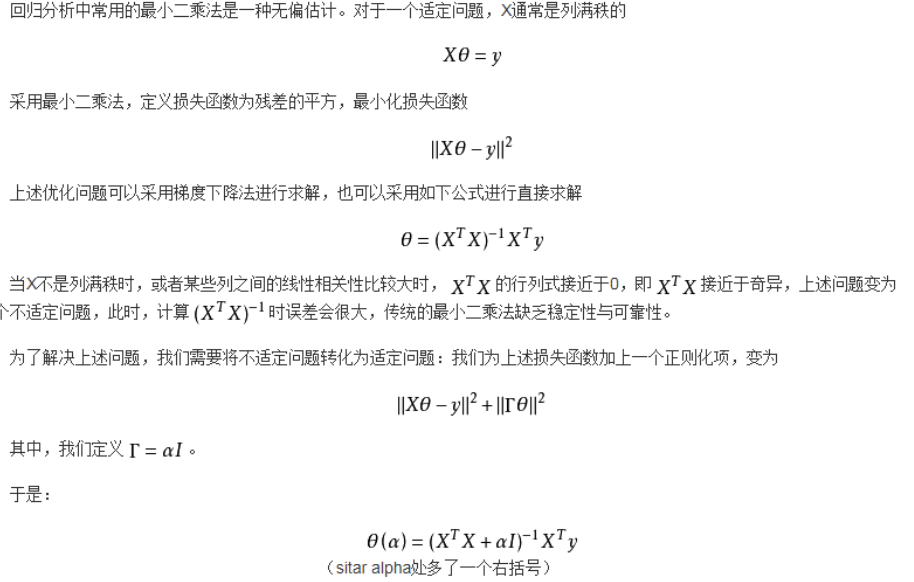

In [10]:
def ridgeRegres(xMat, yMat, lam=0.2):
    '''
        Desc：
            这个函数实现了给定 lambda 下的岭回归求解。
            如果数据的特征比样本点还多，就不能再使用上面介绍的的线性回归和局部线性回归了，因为计算 (xTx)^(-1)会出现错误。
            如果特征比样本点还多（n > m），也就是说，输入数据的矩阵x不是满秩矩阵。非满秩矩阵在求逆时会出现问题。
            为了解决这个问题，我们下边讲一下：岭回归，这是我们要讲的第一种缩减方法。
        Args：
            xMat：样本的特征数据，即 feature
            yMat：每个样本对应的类别标签，即目标变量，实际值
            lam：引入的一个λ值，使得矩阵非奇异
        Returns：
            经过岭回归公式计算得到的回归系数
    '''

    xTx = xMat.T * xMat
    # 岭回归就是在矩阵 xTx 上加一个 λI 从而使得矩阵非奇异，进而能对 xTx + λI 求逆
    denom = xTx + eye(shape(xMat)[1]) * lam
    # 检查行列式是否为零，即矩阵是否可逆，行列式为0的话就不可逆，不为0的话就是可逆。
    if linalg.det(denom) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = denom.I * (xMat.T * yMat)
    return ws

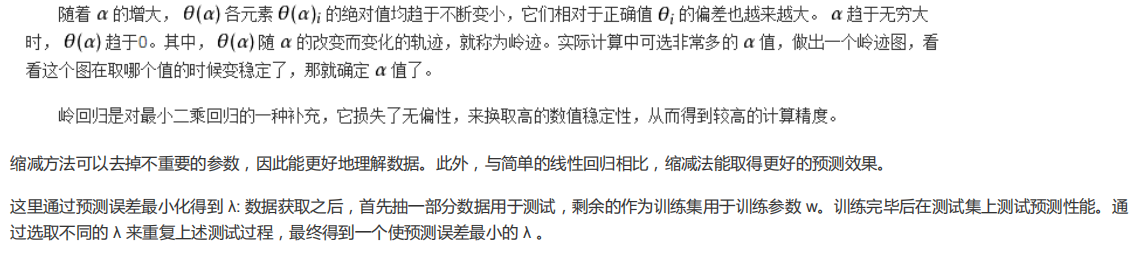

In [11]:
def ridgeTest(xArr, yArr):
    '''
        Desc：
            函数 ridgeTest() 用于在一组 λ 上测试结果
        Args：
            xArr：样本数据的特征，即 feature
            yArr：样本数据的类别标签，即真实数据
        Returns：
            wMat：将所有的回归系数输出到一个矩阵并返回
    '''

    xMat = mat(xArr)
    yMat = mat(yArr).T
    # 计算Y的均值
    yMean = mean(yMat, 0)
    # Y的所有的特征减去均值
    yMat = yMat - yMean
    # 标准化 x，计算 xMat 平均值
    xMeans = mean(xMat, 0)
    # 然后计算 X的方差
    xVar = var(xMat, 0)
    # 所有特征都减去各自的均值并除以方差
    xMat = (xMat - xMeans) / xVar
    # 可以在 30 个不同的 lambda 下调用 ridgeRegres() 函数。
    numTestPts = 30
    # 创建30 * m 的全部数据为0 的矩阵
    wMat = zeros((numTestPts, shape(xMat)[1]))
    for i in range(numTestPts):
        # exp() 返回 e^x 
        ws = ridgeRegres(xMat, yMat, exp(i - 10))
        wMat[i, :] = ws.T
    return wMat

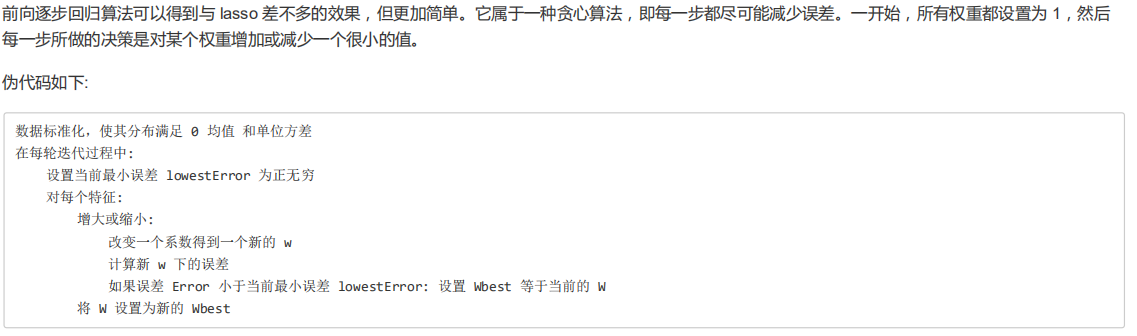

In [12]:
def regularize(xMat):  # 按列进行规范化
    inMat = xMat.copy()
    inMeans = mean(inMat, 0)  # 计算平均值然后减去它
    inVar = var(inMat, 0)  # 计算除以Xi的方差
    inMat = (inMat - inMeans) / inVar
    return inMat


def stageWise(xArr, yArr, eps=0.01, numIt=100):
    xMat = mat(xArr)
    yMat = mat(yArr).T
    yMean = mean(yMat, 0)
    yMat = yMat - yMean  # 也可以规则化ys但会得到更小的coef
    xMat = regularize(xMat)
    m, n = shape(xMat)
    # returnMat = zeros((numIt,n)) # 测试代码删除
    ws = zeros((n, 1))
    wsTest = ws.copy()
    wsMax = ws.copy()
    for i in range(numIt):
        print(ws.T)
        lowestError = inf
        for j in range(n):
            for sign in [-1, 1]:
                wsTest = ws.copy()
                wsTest[j] += eps * sign
                yTest = xMat * wsTest
                rssE = rssError(yMat.A, yTest.A)
                if rssE < lowestError:
                    lowestError = rssE
                    wsMax = wsTest
        ws = wsMax.copy()

测试集

In [14]:

# test for standRegression
def regression1():
    xArr, yArr = loadDataSet("8.Regression/data.txt")
    xMat = mat(xArr)
    yMat = mat(yArr)
    ws = standRegres(xArr, yArr)
    fig = plt.figure()
    ax = fig.add_subplot(
        111)  # add_subplot(349)函数的参数的意思是，将画布分成3行4列图像画在从左到右从上到下第9块
    ax.scatter(
        [xMat[:, 1].flatten()],
        [yMat.T[:, 0].flatten().A[0]])  # scatter 的x是xMat中的第二列，y是yMat的第一列
    xCopy = xMat.copy()
    xCopy.sort(0)
    yHat = xCopy * ws
    ax.plot(xCopy[:, 1], yHat)
    plt.show()


# test for LWLR
def regression2():
    xArr, yArr = loadDataSet("8.Regression/data.txt")
    yHat = lwlrTest(xArr, xArr, yArr, 0.003)
    xMat = mat(xArr)
    srtInd = xMat[:, 1].argsort(
        0)  #argsort()函数是将x中的元素从小到大排列，提取其对应的index(索引)，然后输出
    xSort = xMat[srtInd][:, 0, :]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(xSort[:, 1], yHat[srtInd])
    ax.scatter(
        [xMat[:, 1].flatten().A[0]], [mat(yArr).T.flatten().A[0]],
        s=2,
        c='red')
    plt.show()


# test for abloneDataSet
def abaloneTest():
    '''
    Desc:
        预测鲍鱼的年龄
    Args:
        None
    Returns:
        None
    '''
    # 加载数据
    abX, abY = loadDataSet("8.Regression/abalone.txt")
    # 使用不同的核进行预测
    oldyHat01 = lwlrTest(abX[0:99], abX[0:99], abY[0:99], 0.1)
    oldyHat1 = lwlrTest(abX[0:99], abX[0:99], abY[0:99], 1)
    oldyHat10 = lwlrTest(abX[0:99], abX[0:99], abY[0:99], 10)
    # 打印出不同的核预测值与训练数据集上的真实值之间的误差大小
    print("old yHat01 error Size is :", rssError(abY[0:99], oldyHat01.T))
    print("old yHat1 error Size is :", rssError(abY[0:99], oldyHat1.T))
    print("old yHat10 error Size is :", rssError(abY[0:99], oldyHat10.T))

    # 打印出 不同的核预测值 与 新数据集（测试数据集）上的真实值之间的误差大小
    newyHat01 = lwlrTest(abX[100:199], abX[0:99], abY[0:99], 0.1)
    print("new yHat01 error Size is :", rssError(abY[0:99], newyHat01.T))
    newyHat1 = lwlrTest(abX[100:199], abX[0:99], abY[0:99], 1)
    print("new yHat1 error Size is :", rssError(abY[0:99], newyHat1.T))
    newyHat10 = lwlrTest(abX[100:199], abX[0:99], abY[0:99], 10)
    print("new yHat10 error Size is :", rssError(abY[0:99], newyHat10.T))

    # 使用简单的 线性回归 进行预测，与上面的计算进行比较
    standWs = standRegres(abX[0:99], abY[0:99])
    standyHat = mat(abX[100:199]) * standWs
    print("standRegress error Size is:", rssError(abY[100:199], standyHat.T.A))


# test for ridgeRegression
def regression3():
    abX, abY = loadDataSet("8.Regression/abalone.txt")
    ridgeWeights = ridgeTest(abX, abY)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(ridgeWeights)
    plt.show()


# test for stageWise
def regression4():
    xArr, yArr = loadDataSet("8.Regression/abalone.txt")
    stageWise(xArr, yArr, 0.01, 200)
    xMat = mat(xArr)
    yMat = mat(yArr).T
    xMat = regularize(xMat)
    yM = mean(yMat, 0)
    yMat = yMat - yM
    weights = standRegres(xMat, yMat.T)
    print(weights.T)


# predict for lego's price
def regression5():
    lgX = []
    lgY = []

    setDataCollect(lgX, lgY)
    crossValidation(lgX, lgY, 10)

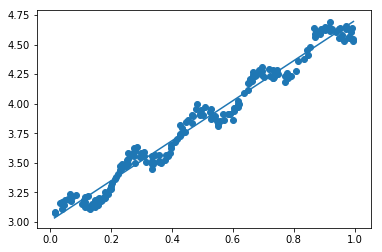

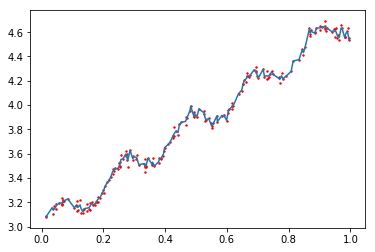

('old yHat01 error Size is :', 56.784209118351797)
('old yHat1 error Size is :', 429.89056187032861)
('old yHat10 error Size is :', 549.11817088260796)
('new yHat01 error Size is :', 23514.971810273342)
('new yHat1 error Size is :', 3207.6896288241887)
('new yHat10 error Size is :', 3320.0892109072443)
('standRegress error Size is:', 518.6363153249365)


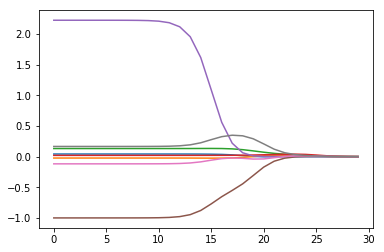

[[ 0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.    0.    0.    0.01  0.    0.    0.    0.  ]]
[[ 0.    0.    0.    0.02  0.    0.    0.    0.  ]]
[[ 0.    0.    0.    0.03  0.    0.    0.    0.  ]]
[[ 0.    0.    0.    0.04  0.    0.    0.    0.  ]]
[[ 0.    0.    0.    0.05  0.    0.    0.    0.  ]]
[[ 0.    0.    0.    0.06  0.    0.    0.    0.  ]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.  ]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.01]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.02]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.03]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.04]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.05]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.06]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.07]]
[[ 0.    0.    0.01  0.06  0.    0.    0.    0.08]]
[[ 0.    0.    0.01  0.05  0.    0.    0.    0.08]]
[[ 0.    0.    0.01  0.05  0.    0.    0.    0.09]]
[[ 0.    0.    0.01  0.05  0.    0.    0.    0.1 ]]
[[ 0.    0.    0.01  0.05  0

In [25]:
if __name__ == "__main__":
    regression1()
    regression2()
    abaloneTest()
    regression3()
    regression4()
    # regression5()

In [27]:
from numpy import *
from bs4 import BeautifulSoup

#从页面读取数据，生成retX和retY列表
def scrapePage(retX, retY, inFile, yr, numPce, origPrc):

    # 打开并读取HTML文件
    fr = open(inFile)
    soup = BeautifulSoup(fr.read(),"html5lib")
    i=1

    # 根据HTML页面结构进行解析
    currentRow = soup.findAll('table', r="%d" % i)
    while(len(currentRow)!=0):
        currentRow = soup.findAll('table', r="%d" % i)
        title = currentRow[0].findAll('a')[1].text
        lwrTitle = title.lower()

        # 查找是否有全新标签
        if (lwrTitle.find('new') > -1) or (lwrTitle.find('nisb') > -1):
            newFlag = 1.0
        else:
            newFlag = 0.0

        # 查找是否已经标志出售，我们只收集已出售的数据
        soldUnicde = currentRow[0].findAll('td')[3].findAll('span')
        if len(soldUnicde)==0:
            print "item #%d did not sell" % i
        else:
            # 解析页面获取当前价格
            soldPrice = currentRow[0].findAll('td')[4]
            priceStr = soldPrice.text
            priceStr = priceStr.replace('$','') #strips out $
            priceStr = priceStr.replace(',','') #strips out ,
            if len(soldPrice)>1:
                priceStr = priceStr.replace('Free shipping', '')
            sellingPrice = float(priceStr)

            # 去掉不完整的套装价格
            if  sellingPrice > origPrc * 0.5:
                    print "%d\t%d\t%d\t%f\t%f" % (yr,numPce,newFlag,origPrc, sellingPrice)
                    retX.append([yr, numPce, newFlag, origPrc])
                    retY.append(sellingPrice)
        i += 1
        currentRow = soup.findAll('table', r="%d" % i)

# 依次读取六种乐高套装的数据，并生成数据矩阵        
def setDataCollect(retX, retY):
    scrapePage(retX, retY, '8.Regression/setHtml/lego8288.html', 2006, 800, 49.99)
    scrapePage(retX, retY, '8.Regression/setHtml/lego10030.html', 2002, 3096, 269.99)
    scrapePage(retX, retY, '8.Regression/setHtml/lego10179.html', 2007, 5195, 499.99)
    scrapePage(retX, retY, '8.Regression/setHtml/lego10181.html', 2007, 3428, 199.99)
    scrapePage(retX, retY, '8.Regression/setHtml/lego10189.html', 2008, 5922, 299.99)
    scrapePage(retX, retY, '8.Regression/setHtml/lego10196.html', 2009, 3263, 249.99)


# 交叉验证测试岭回归
def crossValidation(xArr,yArr,numVal=10):
    # 获得数据点个数，xArr和yArr具有相同长度
    m = len(yArr)
    indexList = range(m)
    errorMat = zeros((numVal,30))

    # 主循环 交叉验证循环
    for i in range(numVal):
        # 随机拆分数据，将数据分为训练集（90%）和测试集（10%）
        trainX=[]; trainY=[]
        testX = []; testY = []

        # 对数据进行混洗操作
        random.shuffle(indexList)

        # 切分训练集和测试集
        for j in range(m):
            if j < m*0.9: 
                trainX.append(xArr[indexList[j]])
                trainY.append(yArr[indexList[j]])
            else:
                testX.append(xArr[indexList[j]])
                testY.append(yArr[indexList[j]])

        # 获得回归系数矩阵
        wMat = ridgeTest(trainX,trainY)

        # 循环遍历矩阵中的30组回归系数
        for k in range(30):
            # 读取训练集和数据集
            matTestX = mat(testX); matTrainX=mat(trainX)
            # 对数据进行标准化
            meanTrain = mean(matTrainX,0)
            varTrain = var(matTrainX,0)
            matTestX = (matTestX-meanTrain)/varTrain

            # 测试回归效果并存储
            yEst = matTestX * mat(wMat[k,:]).T + mean(trainY)

            # 计算误差
            errorMat[i,k] = ((yEst.T.A-array(testY))**2).sum()

    # 计算误差估计值的均值
    meanErrors = mean(errorMat,0)
    minMean = float(min(meanErrors))
    bestWeights = wMat[nonzero(meanErrors==minMean)]

    # 不要使用标准化的数据，需要对数据进行还原来得到输出结果
    xMat = mat(xArr); yMat=mat(yArr).T
    meanX = mean(xMat,0); varX = var(xMat,0)
    unReg = bestWeights/varX

    # 输出构建的模型
    print "the best model from Ridge Regression is:\n",unReg
    print "with constant term: ",-1*sum(multiply(meanX,unReg)) + mean(yMat)


In [28]:
regression5()

2006	800	0	49.990000	85.000000
2006	800	0	49.990000	102.500000
2006	800	0	49.990000	77.000000
item #4 did not sell
2006	800	0	49.990000	162.500000
2002	3096	0	269.990000	699.990000
2002	3096	0	269.990000	602.000000
2002	3096	0	269.990000	515.000000
2002	3096	0	269.990000	510.000000
2002	3096	0	269.990000	375.000000
2002	3096	1	269.990000	1050.000000
2002	3096	0	269.990000	740.000000
2002	3096	1	269.990000	759.000000
2002	3096	0	269.990000	730.000000
2002	3096	1	269.990000	750.000000
item #11 did not sell
2007	5195	0	499.990000	910.000000
2007	5195	1	499.990000	1199.990000
2007	5195	0	499.990000	811.880000
item #4 did not sell
2007	5195	0	499.990000	1324.790000
2007	5195	1	499.990000	850.000000
2007	5195	1	499.990000	800.000000
2007	5195	0	499.990000	810.000000
2007	5195	1	499.990000	1075.000000
2007	5195	0	499.990000	1050.000000
2007	5195	1	499.990000	1199.990000
2007	5195	0	499.990000	1342.310000
2007	5195	1	499.990000	1000.000000
2007	5195	0	499.990000	1780.000000
2007	5195	0	499.990